In [24]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input"))
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from matplotlib import rcParams
%matplotlib inline
le = preprocessing.LabelEncoder()
import re
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix
warnings.filterwarnings('ignore')

['y_train.csv', 'sample_submission.csv', 'X_test.csv', 'X_train.csv']


In [2]:
def balanced_cv(conf_mat):
    assert len(conf_mat.shape) == 2
    rows, columns = conf_mat.shape
    intra_class_scores = np.zeros((1, columns))
    column_sums = np.sum(conf_mat, axis=0)
    for c in range(columns):
        intra_class_scores[0][c] = float(conf_mat[c][c])/column_sums[c]
        
    balanced_score = np.mean(intra_class_scores)
    return balanced_score

In [3]:
data = pd.read_csv('../input/X_train.csv')
sampl = pd.read_csv('../input/sample_submission.csv')
test = pd.read_csv('../input/X_test.csv')
target = pd.read_csv('../input/y_train.csv')

In [4]:
data.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [5]:
target.head(2)

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete


In [6]:
#target = target.drop("group_id",axis=1)

In [7]:
target.head(2)

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete


In [8]:
sampl.head(2)

,series_id,surface
0,0,concrete
1,1,concrete


In [9]:
test.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439
1,0_1,0,1,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273
2,0_2,0,2,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990
3,0_3,0,3,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270
4,0_4,0,4,-0.025548,-0.98866,-0.14792,0.003477,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100


In [10]:
totalt = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([totalt, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
linear_acceleration_Z,0,0.0
linear_acceleration_Y,0,0.0
linear_acceleration_X,0,0.0
angular_velocity_Z,0,0.0
angular_velocity_Y,0,0.0


In [11]:
totalt = test.isnull().sum().sort_values(ascending=False)
percent = (test.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([totalt, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
linear_acceleration_Z,0,0.0
linear_acceleration_Y,0,0.0
linear_acceleration_X,0,0.0
angular_velocity_Z,0,0.0
angular_velocity_Y,0,0.0


There is no missing data in test and train data

In [12]:
data.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000
mean,1904.500000,63.500000,-0.018050,0.075062,0.012458,-0.003804,0.000178,0.008338,-0.019184,0.129281,2.886468,-9.364886
std,1099.853353,36.949327,0.685696,0.708226,0.105972,0.104299,0.117764,0.088677,0.229153,1.870600,2.140067,2.845341
min,0.000000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-36.067000,-121.490000,-75.386000
25%,952.000000,31.750000,-0.705120,-0.688980,-0.089466,-0.106060,-0.040752,-0.033191,-0.090743,-0.530833,1.957900,-10.193000
50%,1904.500000,63.500000,-0.105960,0.237855,0.031949,-0.018704,0.000084,0.005412,-0.005335,0.124980,2.879600,-9.365300
75%,2857.000000,95.250000,0.651803,0.809550,0.122870,0.097215,0.040527,0.048068,0.064604,0.792263,3.798800,-8.522700
max,3809.000000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,73.008000,65.839000


In [13]:
target.describe()

,series_id,group_id
count,3810.000000,3810.000000
mean,1904.500000,37.601312
std,1099.996591,20.982743
min,0.000000,0.000000
25%,952.250000,19.000000
50%,1904.500000,39.000000
75%,2856.750000,55.000000
max,3809.000000,72.000000


In [14]:
test.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000
mean,1907.500000,63.500000,0.031996,0.120651,0.018735,0.004024,0.000401,0.013669,-0.036101,0.125433,2.906588,-9.359811
std,1101.585403,36.949327,0.671977,0.714522,0.108481,0.100957,0.114485,0.089440,0.233791,1.832639,2.094727,2.802670
min,0.000000,0.000000,-0.989720,-0.989810,-0.154680,-0.156270,-2.403300,-1.193000,-1.458200,-35.040000,-107.480000,-83.173000
25%,953.750000,31.750000,-0.648130,-0.744503,-0.112660,-0.098435,-0.037396,-0.029865,-0.089842,-0.486233,2.052100,-10.125000
50%,1907.500000,63.500000,0.132910,0.397860,0.057271,0.022654,0.001107,0.007276,-0.008911,0.112490,2.900300,-9.361700
75%,2861.250000,95.250000,0.575270,0.803600,0.124770,0.083706,0.037827,0.051112,0.057876,0.727250,3.758000,-8.582075
max,3815.000000,127.000000,0.989320,0.988940,0.154250,0.152510,3.396600,1.150700,0.960280,36.628000,55.624000,59.633000


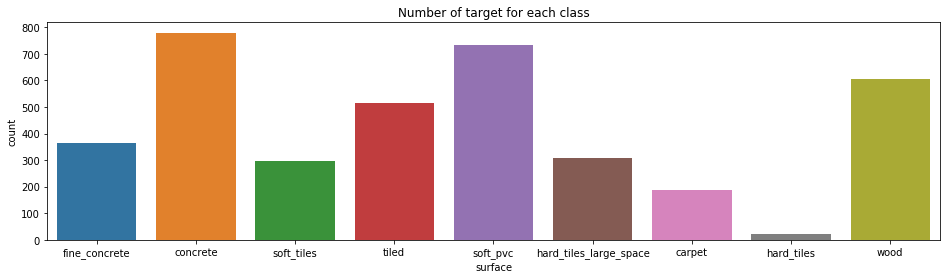

In [15]:
f, ax = plt.subplots(1,1, figsize=(16,4))
g = sns.countplot(target['surface'])
g.set_title("Number of target for each class")
plt.show()   

In [16]:
data.head(1)

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.10765,0.017561,0.000767,-0.74857,2.103,-9.7532


We have to do Data manupulation, since we cannot directly apply any model and fitting. Lets do some feature Engineering
When Dealing with 3Dimensional problem, formula (x^2 + y^2 + z^2)^0.5 can be used
And to Deal with accelearation and velocity problem, general physis formula can be considered

In [17]:
def feat_eng(data):
    df = pd.DataFrame()
    data['totl_anglr_vel'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 +
                             data['angular_velocity_Z'])** 0.5
    data['totl_linr_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 +
                             data['linear_acceleration_Z'])**0.5
    data['totl_xyz'] = (data['orientation_X']**2 + data['orientation_Y']**2 +
                             data['orientation_Z'])**0.5
    #Lets derive one more column since there is a relationship in velocity and acceleration
    # v = u + a*t , u is initial velocty. if u = 0, then v = at means t = v/a
    # but value of acceleration is more and value of velocity is less, lets do a/v relation
    data['acc_vs_vel'] = data['totl_linr_acc'] / data['totl_anglr_vel']
    
    # Deriving more feature, since we are reducing rows now, we should know min,max,mean values
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        df[col + '_mean'] = data.groupby(['series_id'])[col].mean()
        df[col + '_max'] = data.groupby(['series_id'])[col].max()
        df[col + '_min'] = data.groupby(['series_id'])[col].min()
        df[col + '_std'] = data.groupby(['series_id'])[col].std()
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_mean_abs_chg'] = data.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        df[col + '_abs_min'] = data.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        df[col + '_abs_max'] = data.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        df[col + '_abs_avg'] = (df[col + '_abs_min'] + df[col + '_abs_max'])/2
    return df
    

In [18]:
data = feat_eng(data)
test = feat_eng(test)

In [19]:
data.head()

,orientation_X_mean,orientation_X_max,orientation_X_min,orientation_X_std,orientation_X_maxtoMin,orientation_X_mean_abs_chg,orientation_X_abs_min,orientation_X_abs_max,orientation_X_abs_avg,orientation_Y_mean,orientation_Y_max,orientation_Y_min,orientation_Y_std,orientation_Y_maxtoMin,orientation_Y_mean_abs_chg,orientation_Y_abs_min,orientation_Y_abs_max,orientation_Y_abs_avg,orientation_Z_mean,orientation_Z_max,orientation_Z_min,orientation_Z_std,orientation_Z_maxtoMin,orientation_Z_mean_abs_chg,orientation_Z_abs_min,orientation_Z_abs_max,orientation_Z_abs_avg,orientation_W_mean,orientation_W_max,orientation_W_min,orientation_W_std,orientation_W_maxtoMin,orientation_W_mean_abs_chg,orientation_W_abs_min,orientation_W_abs_max,orientation_W_abs_avg,angular_velocity_X_mean,angular_velocity_X_max,angular_velocity_X_min,angular_velocity_X_std,...,linear_acceleration_Z_mean_abs_chg,linear_acceleration_Z_abs_min,linear_acceleration_Z_abs_max,linear_acceleration_Z_abs_avg,totl_anglr_vel_mean,totl_anglr_vel_max,totl_anglr_vel_min,totl_anglr_vel_std,totl_anglr_vel_maxtoMin,totl_anglr_vel_mean_abs_chg,totl_anglr_vel_abs_min,totl_anglr_vel_abs_max,totl_anglr_vel_abs_avg,totl_linr_acc_mean,totl_linr_acc_max,totl_linr_acc_min,totl_linr_acc_std,totl_linr_acc_maxtoMin,totl_linr_acc_mean_abs_chg,totl_linr_acc_abs_min,totl_linr_acc_abs_max,totl_linr_acc_abs_avg,totl_xyz_mean,totl_xyz_max,totl_xyz_min,totl_xyz_std,totl_xyz_maxtoMin,totl_xyz_mean_abs_chg,totl_xyz_abs_min,totl_xyz_abs_max,totl_xyz_abs_avg,acc_vs_vel_mean,acc_vs_vel_max,acc_vs_vel_min,acc_vs_vel_std,acc_vs_vel_maxtoMin,acc_vs_vel_mean_abs_chg,acc_vs_vel_abs_min,acc_vs_vel_abs_max,acc_vs_vel_abs_avg
series_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.75822,-0.75953,0.000363,0.998275,0.000015,0.75822,0.75953,0.758875,-0.634008,-0.63306,-0.63456,0.000471,0.997636,0.000018,0.63306,0.63456,0.633810,-0.105474,-0.104610,-0.106140,0.000432,0.985585,0.000051,0.104610,0.106140,0.105375,-0.106470,-0.105590,-0.107050,0.000389,0.986362,0.000042,0.105590,0.107050,0.106320,-0.002481,0.107650,-0.16041,0.052800,...,0.810443,6.2681,12.512,9.39005,0.128290,0.228377,0.016577,0.046995,13.776727,NaN,0.016577,0.228377,0.122477,2.777849,4.674147,0.721793,0.977110,6.475742,NaN,0.721793,4.674147,2.697970,0.933845,0.934380,0.933377,0.000304,1.001075,0.000036,0.933377,0.934380,0.933879,29.978968,228.042411,6.043898,30.330393,37.731015,NaN,6.043898,228.042411,117.043154
1,-0.958606,-0.95837,-0.95896,0.000151,0.999385,0.000023,0.95837,0.95896,0.958665,0.241867,0.24270,0.24074,0.000499,1.008142,0.000070,0.24074,0.24270,0.241720,0.031650,0.032341,0.030504,0.000508,1.060222,0.000048,0.030504,0.032341,0.031423,-0.146876,-0.145870,-0.148090,0.000521,0.985009,0.000103,0.145870,0.148090,0.146980,0.004605,0.283420,-0.25480,0.092309,...,1.625696,2.7449,16.928,9.83645,0.249509,0.386577,0.019391,0.089971,19.935499,NaN,0.019391,0.386577,0.202984,3.214436,6.175414,0.758170,1.392089,8.145159,NaN,0.758170,6.175414,3.466792,1.004528,1.004888,1.004061,0.000228,1.000824,0.000023,1.004061,1.004888,1.004474,14.176321,60.797417,3.314465,11.735877,18.343054,NaN,3.314465,60.797417,32.055941
2,-0.512057,-0.50944,-0.51434,0.001377,0.990473,0.000041,0.50944,0.51434,0.511890,-0.846171,-0.84490,-0.84779,0.000785,0.996591,0.000024,0.84490,0.84779,0.846345,-0.129371,-0.128520,-0.130300,0.000541,0.986339,0.000059,0.128520,0.130300,0.129410,-0.071082,-0.070378,-0.071535,0.000278,0.983826,0.000044,0.070378,0.071535,0.070957,0.002646,0.141920,-0.15271,0.060168,...,0.893457,5.7442,12.499,9.12160,0.183400,0.311160,0.032987,0.058695,9.432933,NaN,0.032987,0.311160,0.172073,2.957224,5.521865,0.400419,1.443413,13.790228,NaN,0.400419,5.521865,2.961142,0.921325,0.921914,0.920665,0.000378,1.001356,0.000042,0.920665,0.921914,0.921290,18.434759,62.823610,2.782415,13.314597,22.578809,NaN,2.782415,62.823610,32.803013
3,-0.939169,-0.93884,-0.93968,0.000227,0.999106,0.000026,0.93884,0.93968,0.939260,0.3101

In [20]:
# Filling missing data by zeroes
data.fillna(0,inplace=True)
data.replace(-np.inf,0,inplace=True)
data.replace(np.inf,0,inplace=True)
test.fillna(0,inplace=True)
test.replace(-np.inf,0,inplace=True)
test.replace(np.inf,0,inplace=True)

In [21]:
#Label Encoding
target['surface'] = le.fit_transform(target['surface'])

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import gc
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)

In [ ]:
predicted = np.zeros((test.shape[0],9))
measured= np.zeros((data.shape[0]))
score = 0
balanced_cv_sum = 0
for times, (trn_idx, val_idx) in enumerate(folds.split(data.values,target['surface'].values)):
    model = RandomForestClassifier(n_estimators=500)
    model.fit(data.iloc[trn_idx],target['surface'][trn_idx])
    measured[val_idx] = model.predict(data.iloc[val_idx])
    predicted += model.predict_proba(test)/folds.n_splits
    score += model.score(data.iloc[val_idx],target['surface'][val_idx])
    print("Fold: {} score: {}".format(times,model.score(data.iloc[val_idx],target['surface'][val_idx])))
    cm = confusion_matrix(model.predict(data.iloc[val_idx]), target['surface'].iloc[val_idx])
    sns.heatmap(cm, annot=True, cmap="YlOrBr")
    balscore = balanced_cv(cm)
    print('balanced cv score', balscore)
    balanced_cv_sum +=balscore
    gc.collect()
print('Avg Accuracy', score / folds.n_splits)
print('Avg Balanced Accuracy', balanced_cv_sum / folds.n_splits)
    

In [ ]:
sampl['surface'] = le.inverse_transform(predicted.argmax(axis=1))
sampl.to_csv('submission.csv', index=False)
sampl.head()